In [1]:
from unseen import fileio
from unseen import spatial_selection

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import regionmask
import geopandas as gp
import xarray as xr
import numpy as np
import cartopy.io.shapereader as shpreader

## Example region

In [2]:
regions = regionmask.defined_regions.srex
regions

<regionmask.Regions>
Name:     SREX
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...

Regions:
 1 ALA       Alaska/N.W. Canada
 2 CGI     Canada/Greenl./Icel.
 3 WNA         W. North America
 4 CNA         C. North America
 5 ENA         E. North America
..  ..                      ...
22 EAS                  E. Asia
23 SAS                  S. Asia
24 SEA                S.E. Asia
25 NAU             N. Australia
26 SAU S. Australia/New Zealand

[26 regions]

In [3]:
regions.polygons

In [4]:
regions.numbers

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

## Shapefile to regionmask region

In [5]:
shapefile = '/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp'

In [6]:
shapes = gp.read_file(shapefile)

In [7]:
type(shapes.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In [8]:
regions = regionmask.Regions([shapes.geometry[0],])

In [9]:
regions

<regionmask.Regions>
Name:     unnamed

Regions:
0 r0 Region0

[1 regions]

## Read data

In [10]:
infile = '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [11]:
ds = fileio.open_dataset(
    infile,
    metadata_file='/home/599/dbi599/forks/unseen/config/dataset_cafe_daily.yml',
    variables=['pr'],
    spatial_coords=[-40, -20, 140, 160],
    isel={'time': slice(0, 3), 'ensemble': slice(0, 2)},
)

In [12]:
ds

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 10, lon: 8)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon       (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 10, 8), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [14]:
lons = ds["lon"].values
lats = ds["lat"].values

In [15]:
np.diff(lons)

array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])

In [16]:
np.diff(lats)

array([2.02247191, 2.02247191, 2.02247191, 2.02247191, 2.02247191,
       2.02247191, 2.02247191, 2.02247191, 2.02247191])

## Default regionmask selection (centre of cell)

In [17]:
ds_selection = spatial_selection.select_shapefile_regions(ds, shapefile)

In [18]:
ds_selection

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 10, lon: 8)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon       (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 10, 8), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

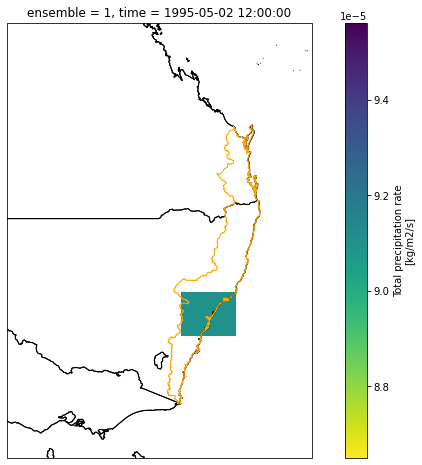

In [26]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_selection['pr'].isel({'time': 1, 'ensemble': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
ax.set_extent([142, 156, -20, -40], crs=ccrs.PlateCarree())
plt.show()

## All-touch method

Grid must have uniform spacing.

https://github.com/regionmask/regionmask/issues/225#issuecomment-915033614

In [20]:
#mask = regionmask.core.mask._mask_rasterize(lons, lats, [shapes.geometry[0]], [1], all_touched=True)
mask = regionmask.core.mask._mask_rasterize(lons, lats, regions.polygons, regions.numbers, all_touched=True)

In [21]:
mask.shape

(10, 8)

In [22]:
#mask = xr.where(mask.notnull(), True, False)
ds_new = ds.where(~np.isnan(mask))

In [23]:
ds_new

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 10, lon: 8)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon       (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 10, 8), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

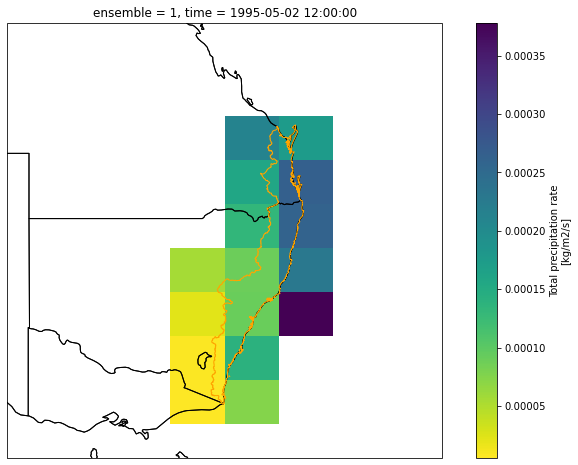

In [28]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_new['pr'].isel({'time': 1, 'ensemble': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',    
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
ax.set_extent([140, 160, -20, -40], crs=ccrs.PlateCarree())
plt.show()

## Percentage overlap method

https://github.com/regionmask/regionmask/issues/38

In [29]:
def sample_coord(coord):
    """Sample coordinates for the fractional overlap calculation."""

    d_coord = coord[1] - coord[0]
    n_cells = len(coord)
    left = coord[0] - d_coord / 2 + d_coord / 20
    right = coord[-1] + d_coord / 2 - d_coord / 20

    return np.linspace(left, right, n_cells * 10)


def overlap_fraction(regions, lon, lat):
    """Calculate the fraction of overlap of regions with lat/lon grid cells.

    Assumes an equally spaced lat/lon grid.

    Args:
       regions (regionmask.Regions)
    """

    # sample with 10 times higher resolution
    lon_sampled = sample_coord(lon)
    lat_sampled = sample_coord(lat)

    mask = regions.mask(lon_sampled, lat_sampled)
    isnan = np.isnan(mask.values)
    numbers = np.unique(mask.values[~isnan])
    numbers = numbers.astype(np.int)

    mask_sampled = list()
    for num in numbers:
        # coarsen the mask again
        mask_coarse = (mask == num).coarsen(lat=10, lon=10).mean()
        mask_sampled.append(mask_coarse)

    mask_sampled = xr.concat(
        mask_sampled, dim="region", compat="override", coords="minimal"
    )
    mask_sampled = mask_sampled.assign_coords(region=("region", numbers))

    return mask_sampled

In [30]:
fraction = overlap_fraction(regions, lons, lats)

<ipython-input-29-aadb5116ba99>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numbers = numbers.astype(np.int)


In [31]:
fraction

<xarray.DataArray 'region' (region: 1, lat: 10, lon: 8)>
array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.2 , 0.21, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.02, 0.59, 0.14, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.22, 0.35, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.15, 0.31, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.11, 0.13, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]]])
Coordinates:
  * lat      (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon      (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * region   (region) int64 0

In [32]:
ds_new = ds.where(fraction.isel(region=0).values > 0.1)

In [33]:
ds_new

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 10, lon: 8)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon       (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 10, 8), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

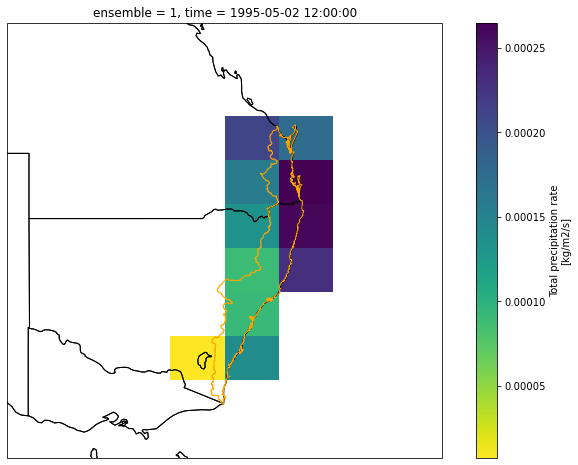

In [34]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_new['pr'].isel({'time': 1, 'ensemble': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
ax.set_extent([140, 160, -20, -40], crs=ccrs.PlateCarree())
plt.show()